In [2]:
import geopandas as gp
import pandas as pd
import pathlib
import numpy as np
from shapely.geometry import LineString, MultiLineString, Point
from shapely import ops
import libpysal
from datetime import datetime
from tqdm import tqdm
import random

# load data frames
import load_data_module

In [3]:
# Load preprocessed data
raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf = load_data_module.raw_full_trip_gdf, load_data_module.raw_trip_sp_gdf, load_data_module.raw_trip_ep_gdf, load_data_module.tesselation_gdf
assert len(raw_full_trip_gdf) == len(raw_trip_sp_gdf) == len(raw_trip_ep_gdf)

raw_full_trip_gdf

PERSON_ID  TRIP_ID           TRIP_START             TRIP_END  \
0         16348   985222  2022-10-31 09:15:57  2022-10-31 09:34:08   
1         16348   985223  2022-10-31 11:04:22  2022-10-31 11:09:12   
2         16348   985301  2022-10-31 11:38:24  2022-10-31 11:43:51   
3         16348   985302  2022-10-31 12:01:50  2022-10-31 12:12:00   
4         16348   985459  2022-10-31 13:23:11  2022-10-31 13:53:17   
...         ...      ...                  ...                  ...   
1380      17269  1003131  2022-11-07 15:01:30  2022-11-07 15:09:31   
1381      17269  1003715  2022-11-07 16:58:18  2022-11-07 17:44:12   
1382      17269  1006304  2022-11-09 17:50:05  2022-11-09 18:17:57   
1383      17269  1009686  2022-11-12 14:03:45  2022-11-12 16:50:44   
1384      17272   988300  2022-11-01 16:14:50  2022-11-01 16:25:47   

      TRIP_LEN_IN_MTRS  TRIP_DURATION_IN_SECS  \
0                 2574                   1090   
1                  353                    290   
2                  315                    327   
3                  335                    608   
4                 3503                   1803   
...                ...                    ...   
1380               676                    481   
1381             10514                   2748   
1382             10279                   1670   
1383             35594                  10014   
1384               468                    638   

                                               geometry    TRIP_WD   TRIP_DATE  
0     LINESTRING (4559166.407 3266303.668, 4559167.4...     Monday  2022-10-31  
1     LINESTRING (4560638.217 3266657.751, 4560638.4...     Monday  2022-10-31  
2     LINESTRING (4560479.973 3266460.097, 4560476.0...     Monday  2022-10-31  
3     LINESTRING (4560586.589 3266540.033, 4560587.0...     Monday  2022-10-31  
4     LINESTRING (4560642.419 3266670.658, 4560643.7...     Monday  2022-10-31  
...                                                 ...        ...         ...  
1380  LINESTRING (4546734.434 3271943.440, 4546751.9...     Monday  2022-11-07  
1381  LINESTRING (4540892.343 3273385.309, 4540890.8...     Monday  2022-11-07  
1382  LINESTRING (4533398.416 3277276.325, 4533406.8...  Wednesday  2022-11-09  
1383  LINESTRING (4533424.828 3277293.282, 4533399.9...   Saturday  2022-11-12  
1384  LINESTRING (4546732.540 3272130.967, 4546732.1...    Tuesday  2022-11-01  

[1024 rows x 9 columns]

In [4]:
print(f"Number of unique users in data: {raw_full_trip_gdf.PERSON_ID.unique().size}\nNumber of Trips: {raw_full_trip_gdf.TRIP_ID.unique().size}\nNumber of Start Points: {raw_trip_sp_gdf.TRIP_ID.unique().size}\nNumber of End Points: {raw_trip_ep_gdf.TRIP_ID.unique().size}")

Number of unique users in data: 62
Number of Trips: 1024
Number of Start Points: 1024
Number of End Points: 1024


# Merge Start Points (SP) and End Points (EP) with Tessellation

In [5]:
# SP
# Spatial join points to polygons
gdf_sp = gp.sjoin(
    tesselation_gdf[["tile_id", "geometry"]],
    raw_trip_sp_gdf,
    how="inner"
).drop('index_right', axis=1)

In [6]:
# Spatial join points to polygons
gdf_ep = gp.sjoin(
    tesselation_gdf[["tile_id", "geometry"]],
    raw_trip_ep_gdf,
    how="inner"
).drop('index_right', axis=1)

# Extract Full Trips that Start and End within Tessellation Area

In [7]:
gdf_sp_ids = gdf_sp.TRIP_ID
gdf_ep_ids = gdf_ep.TRIP_ID

full_trip_gdf = raw_full_trip_gdf.query("TRIP_ID in @gdf_sp_ids and TRIP_ID in @gdf_ep_ids")
trip_sp_gdf = raw_trip_sp_gdf.query("TRIP_ID in @gdf_ep_ids")
trip_ep_gdf = raw_trip_ep_gdf.query("TRIP_ID in @gdf_sp_ids")

gdf_sp = gdf_sp.query("TRIP_ID in @gdf_ep_ids")
gdf_ep = gdf_ep.query("TRIP_ID in @gdf_sp_ids")

assert len(full_trip_gdf) == len(trip_sp_gdf) == len(trip_ep_gdf) == len(gdf_sp) == len(gdf_ep) == len(set(trip_sp_gdf.TRIP_ID).intersection(set(trip_ep_gdf.TRIP_ID))) # this last intersection checks that for all unique trip ids we have exactly ONE SP and EP

print(f"Number of trips that start and end wihin tessellation area: {len(full_trip_gdf)}")

AssertionError: 

# Evaluation Functions

In [10]:
from sklearn import metrics

def evaluate(clustering):
    # Get ground truth labels
    df = full_trip_gdf
    df['ID'] = df.sort_values('TRIP_ID').groupby('PERSON_ID').ngroup() # Sort TRIP ID ascending and set cluster id corresponding to PERSON_ID
    ground_truth = df.sort_values('TRIP_ID').ID.to_list()

    # All of these metrics are symmetric and some of them are accounting for chance depending on the number of classes and clusters present in the data
    score_funcs = [
        ("V-measure", metrics.v_measure_score),
        ("Rand index", metrics.rand_score),
        ("ARI", metrics.adjusted_rand_score),
        ("MI", metrics.mutual_info_score),
        ("NMI", metrics.normalized_mutual_info_score),
        ("AMI", metrics.adjusted_mutual_info_score),
    ]

    for marker, (score_name, score_func) in zip("d^vx.,", score_funcs):
        print(f"{score_name}: {score_func(ground_truth, clustering)}")

In [11]:
def getIndexInList(trip_id):
    """This function takes in a trip_id and returns the list index of this trip's position in the ground truth clustering.

    Args:
        trip_id (int): TRIP_ID

    Returns:
        int: The index of this TRIP_ID in the ground truth clustering vector.
    """
    index_list = full_trip_gdf.sort_values('TRIP_ID').TRIP_ID.to_list()

    return index_list.index(trip_id)


In [79]:
import tslearn.metrics

def LCSS(traj1_linestr, traj2_linestr, eps=0.000004):
    """
    This function takes in two GeoSeries and takes the top entry linestring. It then calculates the Least Common Sub-Sequence metric for these two and returns the value.
    """

    if isinstance(traj1_linestr, gp.GeoSeries):
        s1 = np.add(traj1_linestr.iloc[0].coords.xy[0], traj1_linestr.iloc[0].coords.xy[1])
    else:
        s1 = np.add(traj1_linestr.coords.xy[0], traj1_linestr.coords.xy[1])

    if isinstance(traj2_linestr, gp.GeoSeries):
        s2 = np.add(traj2_linestr.iloc[0].coords.xy[0], traj2_linestr.iloc[0].coords.xy[1])
    else:
        s2 = np.add(traj2_linestr.coords.xy[0], traj2_linestr.coords.xy[1])

    return tslearn.metrics.lcss(s1, s2, eps=eps)

LCSS(full_trip_gdf[full_trip_gdf['TRIP_ID'] == 1013433].geometry, full_trip_gdf[full_trip_gdf['TRIP_ID'] == 1012612].geometry, eps=1)

0.19225634178905207

In [68]:
full_trip_gdf[full_trip_gdf['TRIP_ID'] == 1012612].geometry.iloc[0].coords[1000]

(4546739.186551515, 3271508.9381022267)

In [169]:
def lcss_custom(S1, S2, eps=15):
    """this function computes the largest common subsequence for two sequences S1 and S2 and returns the relative length of the LCSS to the total length of the shorter sequence. 
    The eps parameter controls the maximum distance between two points in the sequences.

    Args:
        S1 (_type_): GeoSeries 1
        S2 (_type_): GeoSeries 2
    """
    S1_len = len(S1.iloc[0].coords)
    S2_len = len(S2.iloc[0].coords)

    
    
    table = [[0] * (S2_len + 1) for _ in range(S1_len + 1)]
    longest = 0
    
    for i, cS1 in enumerate(S1.iloc[0].coords, 1):
        for j, cS2 in enumerate(S2.iloc[0].coords, 1):
            if np.sqrt((cS1[0] - cS2[0]) ** 2 + (cS1[1] - cS2[1]) ** 2):
                length = table[i][j] = table[i - 1][j - 1] + 1
                longest = max(longest, length)
    return longest/min(S1_len, S2_len)

lcss_custom(full_trip_gdf[full_trip_gdf['TRIP_ID'] == 1013433].geometry, full_trip_gdf[full_trip_gdf['TRIP_ID'] == 1012612].geometry)



1.0

In [12]:
import tslearn.metrics
points = [(26406, -6869), (28259, -892)]
# make test array my repeating the 28-element points list 1M times
np_points = np.array(full_trip_gdf[full_trip_gdf['TRIP_ID'] == 1013433].geometry.iloc[0].coords)
np_points2 = np.array(full_trip_gdf[full_trip_gdf['TRIP_ID'] == 1012612].geometry.iloc[0].coords)

In [9]:
dists = [np.sqrt((np_points[i][0] - np_points2[i][0]) ** 2 + (np_points[i][1] - np_points2[i][1]) ** 2) for i in range(len(np_points))]

In [163]:
np.array(full_trip_gdf[full_trip_gdf['TRIP_ID'] == 1013433].geometry.iloc[0].coords)

array([[4544881.81005024, 3274109.79389548],
       [4544878.86630395, 3274107.32069012],
       [4544878.04319686, 3274111.96244558],
       ...,
       [4544273.60240515, 3270530.46303874],
       [4544272.81075542, 3270531.42988332],
       [4544272.5192075 , 3270531.86231975]])

In [13]:
def custom_metric(x, y):
    return np.sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2)

tslearn.metrics.lcss_path_from_metric(np_points, np_points2, metric=custom_metric)

: 

: 

In [167]:
import scipy 

scipy.spatial.distance.cdist(np_points, np_points2, metric=custom_metric)


array([[2929.18515853, 2929.24875074, 2929.67118782, ..., 3624.56049289,
        3624.72746421, 3624.74203596],
       [2929.15052566, 2929.21349857, 2929.63618785, ..., 3621.62328013,
        3621.79008612, 3621.80461247],
       [2933.25439081, 2933.3177371 , 2933.74027443, ..., 3626.05871893,
        3626.22541848, 3626.23991559],
       ...,
       [2800.48538114, 2800.03543807, 2800.30755311, ...,   11.4779838 ,
          11.59786395,   11.64766009],
       [2800.72886481, 2800.27898985, 2800.55126947, ...,   10.24564541,
          10.37095479,   10.42174524],
       [2800.78275594, 2800.33290984, 2800.60525909, ...,    9.7438666 ,
           9.87308935,    9.92456873]])

In [143]:
np.sqrt(np.sum((np_points[0:-2] - np_points[1:-1])**2, axis=1))

array([3.84478699, 4.71417003, 3.54834001, ..., 0.06790274, 0.1303844 ,
       1.24959903])

In [162]:
def lcss_custom(S1, S2, eps=15):
    """this function computes the largest common subsequence for two sequences S1 and S2 and returns the relative length of the LCSS to the total length of the shorter sequence. 
    The eps parameter controls the maximum distance between two points in the sequences.

    Args:
        S1 (_type_): GeoSeries 1
        S2 (_type_): GeoSeries 2
    """

    S1_len = len(S1.iloc[0].coords)
    S2_len = len(S2.iloc[0].coords)

    shorter_sequence = S1 if S1_len < S2_len else S2
    longer_sequence = S1 if S1_len >= S2_len else S2

    # unpack coordinates from GeoSeries
    shorter_sequence = shorter_sequence.iloc[0].coords
    longer_sequence = longer_sequence.iloc[0].coords

    # Create list of lcss values for each alignment
    lcss_values = []

    # create list of 0s with length of shorter sequence
    zero_list = [0] * len(shorter_sequence)

    for alignment in range(abs(S1_len - S2_len)):
        # Create list of distances between points in S1 and S2
        # Len of this list will be equal to length of shorter sequence        

        distances = [np.sqrt((shorter_sequence[i][0] - longer_sequence[i + alignment][0]) ** 2 + (shorter_sequence[i][1] - longer_sequence[i + alignment][1]) ** 2) for i in range(len(shorter_sequence))]

        lcss_values.append(tslearn.metrics.lcss(distances, zero_list, eps=eps))

    return max(lcss_values)

 
lcss_custom(full_trip_gdf[full_trip_gdf['TRIP_ID'] == 1013433].geometry, full_trip_gdf[full_trip_gdf['TRIP_ID'] == 1012612].geometry)


0.1268357810413885

In [58]:
full_trip_gdf[full_trip_gdf['TRIP_ID'] == 1013433].geometry

372    LINESTRING (4544881.810 3274109.794, 4544878.8...
Name: geometry, dtype: geometry

In [45]:
Point(full_trip_gdf[full_trip_gdf['TRIP_ID'] == 1013433].geometry.iloc[0].coords[-100]).distance(Point(full_trip_gdf[full_trip_gdf['TRIP_ID'] == 1012612].geometry.iloc[0].coords[-100]))

11.48307834904173

In [17]:
# Print two examplatory trips to calibrate epsilon value of LCSS function
m = full_trip_gdf[full_trip_gdf['TRIP_ID'] == 1013433].explore()

full_trip_gdf[full_trip_gdf['TRIP_ID'] == 1012612].explore(m=m, color="purple")

# Concatenate Trips

## Build mapping of trip chains

In [53]:
# Calculate mapping of continued trips that happened subsequent to and from same tile
mapping_cont_trips = []
for index, trip in gdf_ep.sort_values('TRIP_ID').iterrows():
    te_1_id = trip.TRIP_ID
    te_1_tid = trip.tile_id
    te_1_dt = pd.to_datetime(trip['TRIP_END'], format='%Y-%m-%d %H:%M:%S')
    ts_1_dt = pd.to_datetime(trip['TRIP_START'], format='%Y-%m-%d %H:%M:%S')

    inflow = gdf_ep.query("tile_id == @te_1_tid")
    inflow['TRIP_END'] = pd.to_datetime(inflow.TRIP_END, format='%Y-%m-%d %H:%M:%S')
    inflow['TRIP_START'] = pd.to_datetime(inflow.TRIP_START, format='%Y-%m-%d %H:%M:%S')
    inflow['INFLOW_HR_DIFF'] = inflow.TRIP_END.apply(lambda x: (x - te_1_dt).total_seconds()/3600)
    inflow = inflow.query("(INFLOW_HR_DIFF <= 4) and (INFLOW_HR_DIFF >= 4)") # Take trips 
    inflow = inflow.query("(TRIP_START > @te_1_dt) or (@ts_1_dt > TRIP_END)") # Ignore trips that have happened simultaneously

    # if more than one trip has arrived in +- hour window, then do not merge this trip
    if len(inflow) > 1:
        continue

    
    # Get all trips that started from same tile as t_1 has ended in
    ts_2 = gdf_sp.query("tile_id == @te_1_tid")

    # if trip has started in tesselation area but ended outside than there will be no endpoint (happened 1 time) TODO
    if ts_2.empty:
        continue

    # get difference between two trips hours (seconds divided by 3600 gets hours)
    ts_2['TRIP_START'] = pd.to_datetime(ts_2.TRIP_START, format='%Y-%m-%d %H:%M:%S')
    ts_2['TRIP_END'] = pd.to_datetime(ts_2.TRIP_END, format='%Y-%m-%d %H:%M:%S')
 
    ts_2['hr_diff'] = ts_2['TRIP_START'].apply(lambda x: (x - te_1_dt).total_seconds()/3600)

    # Only consider trips that started within a certain time after the initial trip ended in the same tessellation tile
    ts_2 = ts_2[(ts_2['hr_diff'].astype(str).astype(float) <= 8) & (ts_2['hr_diff'].astype(str).astype(float) >= 0)]

    # Only consider trips that are not simultaneously
    ts_2 = ts_2.query("(TRIP_START > @te_1_dt) or (@ts_1_dt > TRIP_END)")

    # Only consider connection if exactly one trip started from same tile in time window
    if len(ts_2) == 1:
        mapping_cont_trips.append({
            'TRIP_ID': te_1_id,
            'TRIP_ID_CONT': ts_2.TRIP_ID.iloc[0]
        })
    

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of

## Asses number of correct and false matches

In [54]:
# Print num of matches and erronous ones out of these
mistakes = []
for conn in mapping_cont_trips:
    trip_ids = [conn['TRIP_ID'],  conn['TRIP_ID_CONT']]
    unique_person = raw_full_trip_gdf.query("TRIP_ID in @trip_ids").PERSON_ID.nunique()

    if unique_person > 1:
        mistakes.append(raw_full_trip_gdf.query("TRIP_ID in @trip_ids"))


print(f"Number of edges (matched) between trips: {len(mapping_cont_trips)}")
print(f"Number of wrong matches: {len(mistakes)}")

Number of edges (matched) between trips: 306
Number of wrong matches: 12


In [ ]:
# Plot wrong matches
pd.concat(mistakes, keys=list(range(1,len(mistakes)+1))).reset_index(level=1, drop=True).reset_index(names="CONN_ID").head(6).explore(column="TRIP_ID")

## Merge trips according to matching

In [55]:
def getTripChain(trip_id, chain=[]):
    """
    Recursive function that returns a list for all chained trips for a give orig trip_id
    """
    if type(trip_id) == str:
        trip_id = int(trip_id)

    # add orig trip_id to output list
    if len(chain) == 0:
        chain.append(trip_id)

    # recursively find all chained trips originating from the orig trip_id
    for edge in mapping_cont_trips:
        if edge['TRIP_ID'] == trip_id:
            chain.append(edge['TRIP_ID_CONT'])
            getTripChain(edge['TRIP_ID_CONT'], chain)
            
        
    return chain


assert getTripChain('998178') == [998178]


In [56]:
### Merge trips according to matching

# Get trip chain for each trip
trip_chains = [getTripChain(trip, chain=[]) for trip in gdf_sp.TRIP_ID]

# Sort for longest chain first
trip_chains.sort(key = len, reverse = True)

# Create dictionary to store mappings for evaluation
trip_concat_dict = {}

covered_trips = []
merged_trips_gdf = []
for chain in trip_chains:
    # Check if any of the trips in the current chain has already been merged as part of another chain
    # Since we start with the longest chain and iterate through descending sorted list, we only retain the complete chains
    if set(chain).intersection(set(covered_trips)):
        continue

    # add trip chain to dict for evaluation later
    trip_concat_dict[chain[0]] = chain[1:]
    
    # add all trip ids part of current chain to list so that every trip is only contained in longest chain of it
    covered_trips += chain

    trips = raw_full_trip_gdf.query("TRIP_ID in @chain").sort_values("TRIP_START")
    trips["temp"] = 1

    trips = trips.groupby('temp').agg(list).reset_index(drop=True).rename(columns={'TRIP_ID': 'TRIP_ID_CHAIN'})

    trips["wkt_trip"] = trips['geometry'].apply(lambda x: ", ".join([str(i) for i in x]).replace("), LINESTRING (", ", "))
    trips['TRIP_START'] = trips['TRIP_START'].apply(lambda x: min(x))
    trips['TRIP_END'] = trips['TRIP_END'].apply(lambda x: max(x))
    trips['TRIP_LEN_IN_MTRS'] = trips['TRIP_LEN_IN_MTRS'].apply(lambda x: sum(x))
    trips['TRIP_DURATION_IN_SECS'] = trips['TRIP_DURATION_IN_SECS'].apply(lambda x: sum(x))
    trips['TRIP_WD'] = trips['TRIP_WD'].apply(lambda x: x[0]) # see below
    trips['TRIP_DATE'] = trips['TRIP_DATE'].apply(lambda x: x[0]) # see below
    trips['TRIP_ID'] = trips['TRIP_ID_CHAIN'].apply(lambda x: x[0]) # assign trip_id of first trip in chain to concatenated trip
    # This is the TRIP_ID of the last trip in the chain to be concatenated
    trips['TRIP_ID_LAST'] = trips['TRIP_ID_CHAIN'].apply(lambda x: x[-1]) 

    # Note: Here we are assigning the PERSON_ID of the first trip to the concatenated trip. This of course can be erroneous if the concatenation itself is wrong
    trips['PERSON_ID'] = trips['PERSON_ID'].apply(lambda x: x[0])
    trips = trips.drop(['geometry', 'TRIP_ID_CHAIN'], axis=1)

    trips = gp.GeoDataFrame(trips, geometry=gp.GeoSeries.from_wkt(trips['wkt_trip'])).drop('wkt_trip', axis=1)

    merged_trips_gdf.append(trips)

trip_merged_gdf = pd.concat(merged_trips_gdf)

print(f"Number of trips that were matched at least once: {len(set(covered_trips))}")

Number of trips that were matched at least once: 983


In [57]:
# Concatenate all trips that were unmerged with the merged trips into a new gdf
unmerged_trips = full_trip_gdf.query("TRIP_ID not in @covered_trips")
full_trips_concat_gdf = pd.concat([unmerged_trips, trip_merged_gdf])
full_trips_concat_gdf['TRIP_ID_FIRST'] = full_trips_concat_gdf['TRIP_ID'] # This is the same as TRIP_ID

# Assign TRIP_ID as TRIP_ID_LAST in case TRIP has not been merged and first and last TRIP_Id are in fact the same
full_trips_concat_gdf['TRIP_ID_LAST'] = np.where(full_trips_concat_gdf.TRIP_ID_LAST.isnull(), full_trips_concat_gdf.TRIP_ID, full_trips_concat_gdf.TRIP_ID_LAST)


In [58]:
# Filter for those trip_ids that are still the start of a trip even after the concatenation (of trip chains)
t_id_sp = full_trips_concat_gdf.TRIP_ID_FIRST
t_id_ep = full_trips_concat_gdf.TRIP_ID_LAST

# Also filter dfs that contain points
gdf_sp_concat = gdf_sp.query("TRIP_ID in @t_id_sp")
trip_sp_gdf_concat = trip_sp_gdf.query("TRIP_ID in @t_id_sp")

gdf_ep_concat = gdf_ep.query("TRIP_ID in @t_id_ep")
trip_ep_gdf_concat = trip_ep_gdf.query("TRIP_ID in @t_id_ep")

assert len(trip_sp_gdf_concat) == len(trip_ep_gdf_concat) == len(gdf_sp_concat) == len(gdf_ep_concat)

## Create clustering after concatenation step

In [59]:
# This creates the array with clustering IDs after the concatenation step
clustering_concat = {}
for index, trip in full_trips_concat_gdf.reset_index().sort_values('TRIP_ID').iterrows():
    trip_order_index = getIndexInList(trip.TRIP_ID)

    clustering_concat[trip_order_index] = index

    if trip.TRIP_ID in trip_concat_dict:
        for t in trip_concat_dict[trip.TRIP_ID]:
            clustering_concat[getIndexInList(t)] = index

clustering_concat = list(dict(sorted(clustering_concat.items())).values())

print(f"Number of unique clusters: {len(set(clustering_concat))}")

Number of unique clusters: 703


# Build Home Locations (HL)

## From Start Points (SPs)

We use the SP-tessellation matching that still contains all SP (and potential HL), and not just the SP and EP of the concatenated trips. We do this, because we do not want loose 

In [96]:
# Generate home locations (HL) from SPs
gdf_sp.index=pd.to_datetime(gdf_sp.TRIP_START)
gdf_sp['hl'] = gdf_sp['TRIP_START'].apply(lambda x: 1 if x in gdf_sp.between_time('6:00', '10:00').TRIP_START else 0).astype(object)
gdf_sp.reset_index(inplace=True, drop=True)
gdf_sp

tile_id                                           geometry  PERSON_ID  \
0    141123  POLYGON ((4521944.972 3262612.350, 4521940.000...      16657   
1    160374  POLYGON ((4525804.524 3258010.414, 4525799.460...      16657   
2    164894  POLYGON ((4526563.199 3260361.564, 4526558.115...      16657   
3    167779  POLYGON ((4525459.866 3298373.203, 4525454.791...      16363   
4    170037  POLYGON ((4527545.317 3260280.405, 4527540.208...      16657   
..      ...                                                ...        ...   
991  426691  POLYGON ((4575650.048 3274355.578, 4575643.742...      16972   
992  426696  POLYGON ((4575618.520 3274963.100, 4575612.214...      16972   
993  429269  POLYGON ((4576099.224 3275109.771, 4576092.907...      16972   
994  429269  POLYGON ((4576099.224 3275109.771, 4576092.907...      16972   
995  449209  POLYGON ((4579828.575 3276156.867, 4579822.164...      16972   

     TRIP_ID           TRIP_START             TRIP_END  TRIP_LEN_IN_MTRS  \
0     992891  2022-11-03 11:47:30  2022-11-03 14:39:09             13072   
1    1005274  2022-11-08 18:31:46  2022-11-08 18:48:55              6678   
2    1005273  2022-11-08 17:51:38  2022-11-08 18:02:55              3854   
3    1011057  2022-11-13 19:00:13  2022-11-13 19:44:09             45556   
4     999320  2022-11-05 15:56:10  2022-11-05 16:10:08              1278   
..       ...                  ...                  ...               ...   
991  1005667  2022-11-09 06:58:11  2022-11-09 07:00:11               273   
992   985709  2022-10-31 17:48:48  2022-10-31 17:59:43              3194   
993   999784  2022-11-05 17:49:52  2022-11-05 18:35:25             25821   
994  1005191  2022-11-08 13:07:32  2022-11-08 14:08:45             32769   
995  1006387  2022-11-09 18:03:52  2022-11-09 18:16:17              5731   

     TRIP_DURATION_IN_SECS    TRIP_WD   TRIP_DATE       LONG        LAT hl  
0                    10296   Thursday  2022-11-03  12.955835  52.436510  0  
1                     1028    Tuesday  2022-11-08  13.010955  52.393532  0  
2                      677    Tuesday  2022-11-08  13.023055  52.415306  0  
3                     2635     Sunday  2022-11-13  13.030424  52.756936  0  
4                      838   Saturday  2022-11-05  13.037317  52.413978  0  
..                     ...        ...         ...        ...        ... ..  
991                    120  Wednesday  2022-11-09  13.753683  52.519917  1  
992                    655     Monday  2022-10-31  13.754448  52.525464  0  
993                   2732   Saturday  2022-11-05  13.760897  52.526300  0  
994                   3672    Tuesday  2022-11-08  13.761264  52.526422  0  
995                    745  Wednesday  2022-11-09  13.817761  52.534313  0  

[996 rows x 13 columns]

In [97]:
# Extract only those cells that are HL
gdf_hl_sp = gdf_sp[gdf_sp['hl'] == 1]

In [98]:
# create spatial weights matrix
W = libpysal.weights.Queen.from_dataframe(gdf_hl_sp)

# get component labels
components = W.component_labels

gdf_hl_combined_sp = pd.merge(gp.sjoin(
    gdf_hl_sp,
    gdf_hl_sp.dissolve(by=components)[["geometry"]],
    how="left"
), gdf_hl_sp.dissolve(by=components)[["geometry"]].reset_index(), left_on="index_right", right_on='index', suffixes=("__drop", "")).drop(['index', 'index_right', 'geometry__drop'], axis=1)

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 63 disconnected components.
 There are 39 islands with ids: 0, 1, 2, 3, 10, 11, 12, 17, 18, 19, 20, 21, 22, 38, 40, 41, 45, 46, 47, 61, 62, 63, 66, 67, 73, 74, 75, 76, 77, 78, 96, 104, 107, 117, 118, 119, 120, 125, 126.
  warnings.warn(message)


In [99]:
# Compute count of unique HL per Peson (HL here is already the merged tiles)
gdf_hl_combined_sp = pd.merge(gdf_hl_combined_sp, gdf_hl_combined_sp.astype({'geometry': 'string'}).groupby('PERSON_ID')[['geometry']].nunique().reset_index().rename(columns={'geometry': 'CNT_UNIQUE_HL'}), how="left")

# TODO: Add number of trips per merged tile
#gdf_hl_combined_sp = pd.merge(gdf_hl_combined_sp, gdf_hl_combined_sp.groupby(['PERSON_ID', 'geometry']).nunique().reset_index()[['PERSON_ID', 'TRIP_ID']].rename(columns={'TRIP_ID': 'CNT_TRIPS_PER_HL'}), suffixes=("", "_drop"))

# using dictionary to convert specific columns
convert_dict = {'PERSON_ID': object,
                'CNT_UNIQUE_HL': int
                }
 
gdf_hl_combined_sp = gdf_hl_combined_sp.astype(convert_dict)

## From End Points (EPs)

<AxesSubplot: ylabel='Frequency'>

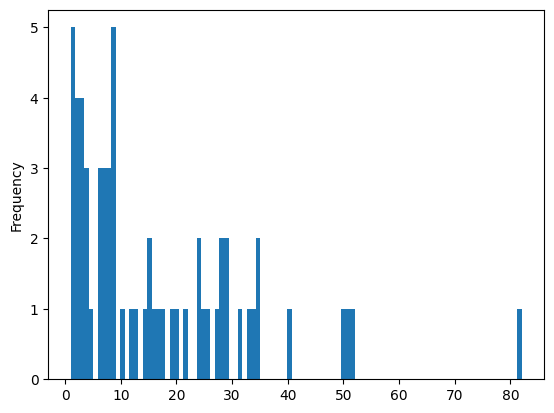

In [100]:
raw_trip_ep_gdf.groupby('PERSON_ID').count().TRIP_ID.plot.hist(bins=100)

<AxesSubplot: ylabel='Frequency'>

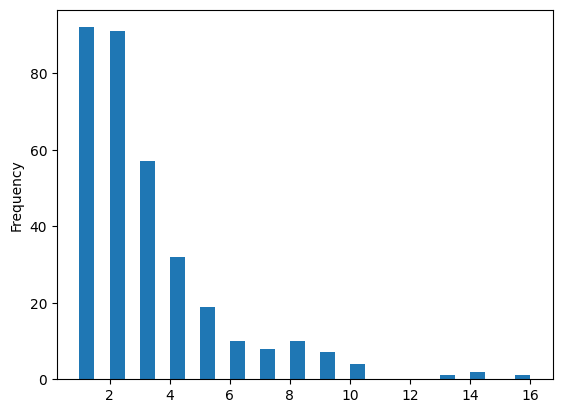

In [101]:
raw_trip_ep_gdf.groupby(['PERSON_ID', 'TRIP_DATE']).count().reset_index('TRIP_DATE').TRIP_ID.plot.hist(bins=30)

In [102]:
# Generate home locations (HL) from EPs
gdf_ep.index=pd.to_datetime(gdf_ep.TRIP_END)
gdf_ep['hl'] = gdf_ep['TRIP_END'].apply(lambda x: 1 if x in gdf_ep.between_time('18:00', '00:00').TRIP_END else 0).astype(object)
gdf_ep.reset_index(inplace=True, drop=True)
gdf_ep

tile_id                                           geometry  PERSON_ID  \
0    160374  POLYGON ((4525804.524 3258010.414, 4525799.460...      16657   
1    166822  POLYGON ((4526934.672 3260254.950, 4526929.579...      16657   
2    167780  POLYGON ((4525454.791 3298494.109, 4525449.717...      16363   
3    170038  POLYGON ((4527540.208 3260402.256, 4527535.100...      16657   
4    174536  POLYGON ((4528410.473 3260072.460, 4528405.343...      16363   
..      ...                                                ...        ...   
991  426691  POLYGON ((4575650.048 3274355.578, 4575643.742...      16972   
992  426691  POLYGON ((4575650.048 3274355.578, 4575643.742...      16972   
993  426716  POLYGON ((4575492.429 3277392.436, 4575486.125...      16972   
994  427337  POLYGON ((4575752.893 3274726.390, 4575746.584...      16363   
995  449209  POLYGON ((4579828.575 3276156.867, 4579822.164...      16972   

     TRIP_ID           TRIP_START             TRIP_END  TRIP_LEN_IN_MTRS  \
0    1005273  2022-11-08 17:51:38  2022-11-08 18:02:55              3854   
1     992891  2022-11-03 11:47:30  2022-11-03 14:39:09             13072   
2    1010710  2022-11-13 11:48:57  2022-11-13 12:51:38             46105   
3     999087  2022-11-05 15:19:38  2022-11-05 15:29:28               857   
4     987540  2022-11-01 10:03:42  2022-11-01 10:06:14               343   
..       ...                  ...                  ...               ...   
991   997767  2022-11-05 02:11:43  2022-11-05 02:51:31             22005   
992   997265  2022-11-04 20:17:49  2022-11-04 20:20:07               127   
993   985709  2022-10-31 17:48:48  2022-10-31 17:59:43              3194   
994   985353  2022-10-31 10:37:56  2022-10-31 11:25:39             23717   
995  1006228  2022-11-09 16:47:53  2022-11-09 17:04:16              5563   

     TRIP_DURATION_IN_SECS    TRIP_WD   TRIP_DATE       LONG        LAT hl  
0                      677    Tuesday  2022-11-08  13.010944  52.393673  1  
1                    10296   Thursday  2022-11-03  13.028853  52.413952  0  
2                     3750     Sunday  2022-11-13  13.030126  52.757131  0  
3                      590   Saturday  2022-11-05  13.037416  52.414257  0  
4                      152    Tuesday  2022-11-01  13.050717  52.411690  0  
..                     ...        ...         ...        ...        ... ..  
991                   2386   Saturday  2022-11-05  13.753575  52.519838  0  
992                    138     Friday  2022-11-04  13.753543  52.519858  1  
993                    655     Monday  2022-10-31  13.754873  52.547594  0  
994                   2863     Monday  2022-10-31  13.755188  52.522951  0  
995                    980  Wednesday  2022-11-09  13.817812  52.534326  0  

[996 rows x 13 columns]

In [103]:
# Extract only those cells that are HL
gdf_hl_ep = gdf_ep[gdf_ep['hl'] == 1]

In [104]:
### Merge hl cells that are adjacent (touching) to each other 

# create spatial weights matrix
W = libpysal.weights.Queen.from_dataframe(gdf_hl_ep)

# get component labels
components = W.component_labels

gdf_hl_combined_ep = pd.merge(gp.sjoin(
    gdf_hl_ep,
    gdf_hl_ep.dissolve(by=components)[["geometry"]],
    how="left"
), gdf_hl_ep.dissolve(by=components)[["geometry"]].reset_index(), left_on="index_right", right_on='index', suffixes=("__drop", "")).drop(['index', 'index_right', 'geometry__drop'], axis=1)

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 134 disconnected components.
 There are 68 islands with ids: 0, 4, 7, 26, 27, 30, 31, 38, 39, 42, 46, 62, 64, 65, 66, 72, 73, 74, 87, 89, 92, 99, 106, 113, 131, 134, 135, 140, 141, 143, 147, 155, 156, 161, 165, 166, 167, 170, 177, 180, 183, 184, 185, 186, 187, 192, 197, 214, 231, 232, 237, 240, 243, 244, 245, 246, 260, 266, 270, 276, 277, 280, 293, 296, 297, 298, 303, 304.
  warnings.warn(message)


In [105]:
gdf_hl_combined_ep = pd.merge(gdf_hl_combined_ep, gdf_hl_combined_ep.astype({'geometry': 'string'}).groupby('PERSON_ID')[['geometry']].nunique().reset_index().rename(columns={'geometry': 'CNT_UNIQUE_HL'}), how="left")

# using dictionary to convert specific columns
convert_dict = {'PERSON_ID': object,
                'CNT_UNIQUE_HL': int
                }
 
gdf_hl_combined_ep = gdf_hl_combined_ep.astype(convert_dict)

## Merge (inner join)

In [ ]:
# Spatial join points to 
gdf_hl_combined = gp.sjoin(
    gdf_hl_combined_ep[["geometry"]],
    gdf_hl_combined_sp,
    how="inner"
).drop_duplicates(subset=['PERSON_ID', 'TRIP_ID']).drop('index_right', axis=1)

In [ ]:
# get number of unique HL per user
gdf_hl_combined = pd.merge(gdf_hl_combined, gdf_hl_combined.astype({'geometry': 'string'}).groupby('PERSON_ID')[['geometry']].nunique().reset_index().rename(columns={'geometry': 'CNT_UNIQUE_HL'}), suffixes=("_drop", ""), how="left", left_on='PERSON_ID', right_on='PERSON_ID').drop('CNT_UNIQUE_HL_drop', axis=1)


In [ ]:
gdf_hl_combined = pd.merge(gdf_hl_combined.astype({'geometry':'string'}), gdf_hl_combined.astype({'geometry':'string'}).groupby('geometry').count().reset_index().rename(columns={'tile_id': 'CNT_TRIPS_PER_GEOM'})[['geometry', 'CNT_TRIPS_PER_GEOM']], left_on="geometry", right_on="geometry")
geometry = gp.GeoSeries.from_wkt(gdf_hl_combined['geometry'])
gdf_hl_combined = gp.GeoDataFrame(gdf_hl_combined, geometry=geometry)


In [ ]:
# Get the trips that are from PERSON_IDs that overlap in their hl
intersected_person_id = pd.merge(gdf_hl_combined.astype({'geometry':'string'}), gdf_hl_combined.astype({'geometry':'string'}).groupby(['geometry'])[['PERSON_ID']].nunique().reset_index(), left_on="geometry", right_on="geometry", how="left")
intersected_person_id = intersected_person_id[intersected_person_id.PERSON_ID_y > 1]
intersected_person_id

geometry tile_id PERSON_ID_x  \
3    MULTIPOLYGON (((13.19814022115662 52.531346546...  228016       16659   
4    MULTIPOLYGON (((13.19814022115662 52.531346546...  227372       16356   
5    MULTIPOLYGON (((13.19814022115662 52.531346546...  227372       16356   
6    MULTIPOLYGON (((13.19814022115662 52.531346546...  227372       16356   
24   MULTIPOLYGON (((13.325700991501593 52.51166923...  274293       16656   
25   MULTIPOLYGON (((13.325700991501593 52.51166923...  273651       16972   
46   MULTIPOLYGON (((13.34726055832046 52.547737578...  280755       16970   
47   MULTIPOLYGON (((13.34726055832046 52.547737578...  280755       16643   
48   MULTIPOLYGON (((13.34726055832046 52.547737578...  280755       16643   
49   MULTIPOLYGON (((13.34726055832046 52.547737578...  280755       16643   
50   MULTIPOLYGON (((13.34726055832046 52.547737578...  280755       16643   
51   MULTIPOLYGON (((13.34726055832046 52.547737578...  280755       16643   
52   MULTIPOLYGON (((13.34726055832046 52.547737578...  280756       16643   
53   MULTIPOLYGON (((13.34726055832046 52.547737578...  280113       16643   
65   POLYGON ((13.36882012513933 52.523695304532815...  289094       16363   
66   POLYGON ((13.36882012513933 52.523695304532815...  289094       16655   
103  POLYGON ((13.411939258777068 52.54992258656927...  305191       16658   
104  POLYGON ((13.411939258777068 52.54992258656927...  304549       17266   

     TRIP_ID           TRIP_START             TRIP_END  TRIP_LEN_IN_MTRS  \
3    1004199  2022-11-08 07:25:09  2022-11-08 08:02:23              9099   
4    1013650  2022-11-16 09:31:22  2022-11-16 10:07:36              9546   
5     992654  2022-11-03 08:41:46  2022-11-03 08:53:46              1061   
6     985179  2022-10-31 09:29:04  2022-10-31 10:02:12              9624   
24   1002751  2022-11-07 09:51:43  2022-11-07 09:55:28               819   
25   1006129  2022-11-09 09:43:13  2022-11-09 10:15:13              7980   
46    992614  2022-11-03 08:59:51  2022-11-03 09:33:54              7811   
47   1009255  2022-11-12 09:37:11  2022-11-12 09:56:50              5788   
48    986203  2022-11-01 08:12:21  2022-11-01 08:55:42             18097   
49   1006736  2022-11-10 09:22:15  2022-11-10 10:05:08             14635   
50   1002821  2022-11-07 09:38:34  2022-11-07 10:14:36             14185   
51    989408  2022-11-02 09:41:30  2022-11-02 10:02:34              5954   
52   1008464  2022-11-11 09:58:12  2022-11-11 10:46:59             14619   
53    994016  2022-11-04 09:38:08  2022-11-04 10:01:29              6226   
65    987381  2022-11-01 09:09:32  2022-11-01 09:34:36             23323   
66   1008100  2022-11-11 06:42:34  2022-11-11 09:16:55            342511   
103  1011249  2022-11-14 08:34:56  2022-11-14 08:57:42              8265   
104   994920  2022-11-04 09:53:40  2022-11-04 09:56:38               666   

     TRIP_DURATION_IN_SECS    TRIP_WD   TRIP_DATE       LONG        LAT hl  \
3                     2233    Tuesday  2022-11-08  13.199311  52.532641  1   
4                     2172  Wednesday  2022-11-16  13.196940  52.531809  1   
5                      720   Thursday  2022-11-03  13.196940  52.531809  1   
6                     1986     Monday  2022-10-31  13.197644  52.531802  1   
24                     223     Monday  2022-11-07  13.327644  52.512145  1   
25                    1918  Wednesday  2022-11-09  13.325718  52.513387  1   
46                    2028   Thursday  2022-11-03  13.347083  52.546729  1   
47                    1179   Saturday  2022-11-12  13.345915  52.547440  1   
48                    2535    Tuesday  2022-11-01  13.345830  52.547472  1   
49                    2568   Thursday  2022-11-10  13.345649  52.547704  1   
50                    2160     Monday  2022-11-07  13.345801  52.547492  1   
51                    1264  Wednesday  2022-11-02  13.345867  52.547496  1   
52                    2910     Friday  2022-11-11  13.345655  52.547906  1   
53                    1401

<AxesSubplot: ylabel='Frequency'>

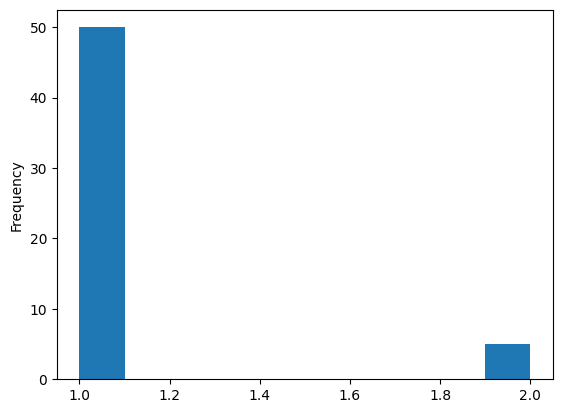

In [ ]:
gdf_hl_combined.astype({'geometry':'string'}).groupby(['geometry'])[['PERSON_ID']].nunique().PERSON_ID.plot.hist()

In [ ]:
gdf_hl_combined.PERSON_ID.unique().size

42

In [ ]:
gdf_hl_combined.explore(column="PERSON_ID")

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\geopandas\explore.py:362: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cat = pd.Categorical(gdf[column][~nan_idx], categories=categories)


## Merge (concatenate)

In [137]:
gp_combined = pd.concat([gdf_hl_combined_ep, gdf_hl_combined_sp])

In [138]:
### Merge hl cells that are adjacent (touching) to each other 

# create spatial weights matrix
W = libpysal.weights.Queen.from_dataframe(gp_combined)

# get component labels
components = W.component_labels

# We need to first join and then merge to first get the right index and then actually join the geometry 
gp_combined = pd.merge(gp.sjoin(
    gp_combined,
    gp_combined.dissolve(by=components)[["geometry"]],
    how="left"
), gp_combined.dissolve(by=components)[["geometry"]].reset_index(), left_on="index_right", right_on='index', suffixes=("__drop", "")).drop(['index', 'index_right', 'geometry__drop'], axis=1)

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 164 disconnected components.
 There are 88 islands with ids: 0, 4, 7, 26, 27, 30, 31, 38, 42, 46, 63, 65, 72, 73, 88, 89, 92, 100, 106, 117, 133, 134, 135, 141, 142, 143, 148, 155, 161, 165, 166, 167, 170, 177, 180, 183, 184, 185, 186, 187, 192, 214, 231, 232, 237, 240, 243, 244, 245, 246, 260, 266, 270, 277, 280, 293, 296, 297, 298, 303, 304, 312, 313, 314, 321, 322, 323, 329, 330, 331, 332, 333, 352, 356, 357, 358, 373, 374, 377, 378, 386, 387, 407, 418, 428, 430, 436, 437.
  warnings.warn(message)


In [139]:
gp_combined = pd.merge(gp_combined.drop('CNT_UNIQUE_HL', axis=1), gp_combined.astype({'geometry': 'string'}).groupby('PERSON_ID')[['geometry']].nunique().reset_index().rename(columns={'geometry': 'CNT_UNIQUE_HL'}), how="left")

# using dictionary to convert specific columns
convert_dict = {'PERSON_ID': object,
                'CNT_UNIQUE_HL': int
                }
 
gp_combined = gp_combined.astype(convert_dict)

<AxesSubplot: ylabel='Frequency'>

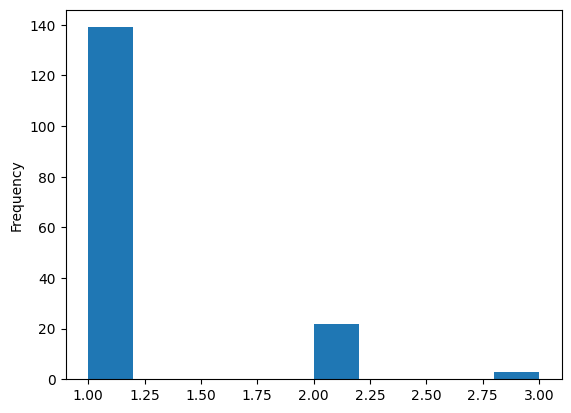

In [140]:
# Plot the number of unique users per HL tile (count of 1 means that the HL has only trips from one unique user, thus perfect clustering)
gp_combined.astype({'geometry':'string'}).groupby(['geometry'])[['PERSON_ID']].nunique().PERSON_ID.plot.hist()

In [141]:
# Number of unique users for which at least one HL was identified
gp_combined.PERSON_ID.unique().size

54

In [ ]:
se_trips = pd.concat([trip_sp_gdf.rename(columns={'TRIP_SP': 'geometry'}), trip_ep_gdf.rename(columns={'TRIP_EP': 'geometry'})]).astype({'TRIP_ID':'object', 'PERSON_ID':'object'}).sort_values('TRIP_ID')


se_trips[se_trips['PERSON_ID'].isin(random.sample(se_trips.PERSON_ID.to_list(), 10))].explore(column="PERSON_ID", marker_kwds=dict(radius=10, fill=True))

In [142]:
# Assign ID to HL
gp_combined['HL_ID'] = gp_combined.astype({'geometry': 'string'}).groupby('geometry').ngroup()

HL_table = gp_combined[['geometry', 'HL_ID']].drop_duplicates()

print(f"Number of unique HL tiles: {len(HL_table)}")

Number of unique HL tiles: 164


# Match trips with Home Location tiles

## Match individual (non-concatenated trips)

In [274]:
# Merge all start and enpoints of all trajectories with HL tiles
# All successfully matched trips will have 0 in the "matched_sp/ep" column else NaN
matched_sp = gp.sjoin(
    trip_sp_gdf,
    gp_combined.dissolve()[['geometry']], # Here we do the matching on the dissolved HL tiles since we only want to have one match per point to detect binary whether it is matched at all or not
    how="left"
).rename(columns={"index_right": "matched_sp"})

matched_ep = gp.sjoin(
    trip_ep_gdf,
    gp_combined.dissolve()[['geometry']], # same here, see above
    how="left"
).rename(columns={"index_right": "matched_ep"})


**Note:** Since we here match with the dissolved tile, we also can at max get ONE match per SP since overlapping HL tiles are dissolved.

In [275]:
s = gp.sjoin(
    trip_sp_gdf,
    HL_table,
    how="right").drop('index_left', axis=1).dropna()

In [276]:
e = gp.sjoin(
    trip_ep_gdf,
    HL_table, 
    how="right").drop('index_left', axis=1).dropna()

In [ ]:
# plot unmatched trips
m = full_trip_gdf.query('TRIP_ID in @unmatched_sp_t_ids and TRIP_ID in @unmatched_ep_t_ids').head(10).explore()
HL_table.explore(m=m)

In [277]:
# Get unmatched start and endpoints
unmatched_sp_t_ids = matched_sp[matched_sp.matched_sp.isnull()].TRIP_ID.to_list()
unmatched_ep_t_ids = matched_ep[matched_ep.matched_ep.isnull()].TRIP_ID.to_list()

# Number of unmatched trajectories that do not start or end in an HL tile
print(f"Number of unmatched trajectories (non-concatenated) that do neither start nor end in a HL tile: {len(full_trip_gdf.query('TRIP_ID in @unmatched_sp_t_ids and TRIP_ID in @unmatched_ep_t_ids'))}")

# Get TRIP_IDs of matched start and endpoints
matched_sp_t_ids = matched_sp[~matched_sp.matched_sp.isnull()].TRIP_ID.to_list()
matched_ep_t_ids = matched_ep[~matched_ep.matched_ep.isnull()].TRIP_ID.to_list()

print(f"Number of trajectories (non-concatenated) that start AND end in a HL tile: {len(full_trip_gdf.query('TRIP_ID in @matched_sp_t_ids and TRIP_ID in @matched_ep_t_ids'))}")

# check whether number of unmatched trajectories plus number of matched trajectories do line up with the total number of trips in data
assert (pd.concat([s,e]).TRIP_ID.nunique() + len(full_trip_gdf.query('TRIP_ID in @unmatched_sp_t_ids and TRIP_ID in @unmatched_ep_t_ids'))) == len(full_trip_gdf)

Number of unmatched trajectories (non-concatenated) that do neither start nor end in a HL tile: 231
Number of trajectories (non-concatenated) that start AND end in a HL tile: 331


In [280]:
# Create Lookup table that contains the trip IDs and their respective HL_ID
se_HL_table = pd.concat([s,e]).drop_duplicates(['TRIP_ID', 'HL_ID']).reset_index(drop=True)
double_matched_trips = se_HL_table.drop_duplicates(['TRIP_ID', 'HL_ID'])[se_HL_table.drop_duplicates(['TRIP_ID', 'HL_ID']).duplicated(subset='TRIP_ID', keep=False)].sort_values('TRIP_ID')

print(f"Number of trips that match different HL tiles with their SP and EP: {se_HL_table.drop_duplicates(['TRIP_ID', 'HL_ID']).duplicated(['TRIP_ID']).sum()}")

Number of trips that match different HL tiles with their SP and EP: 164


**Note:** The lookup table *se_HL_table* contains doubly matched trips and does not contain unmatched trips. Therefore, its length is the total number of trips minus the unmatched plus the double matched trips.

Plot double matched trips and the corresponding HL tiles.

In [ ]:
m = full_trip_gdf.query("TRIP_ID in @double_matched_trips.TRIP_ID").head(10).explore(column="TRIP_ID")
HL_table.explore(m=m, column="HL_ID")

## Match concatenated trips

In [1]:
# Merge all start and enpoints of all trajectories with HL tiles
# All successfully matched trips will have 0 in the "matched_sp/ep" column else NaN
matched_sp = gp.sjoin(
    trip_sp_gdf_concat, # This data frame contains all SPs of the trips that are at the end of a concatenated trip (end of a concatenated trip)
    gp_combined.dissolve()[['geometry']], # Here we do the matching on the dissolved HL tiles since we only want to have one match per point to detect binary whether it is matched at all or not
    how="left"
).rename(columns={"index_right": "matched_sp"})

matched_ep = gp.sjoin(
    trip_ep_gdf_concat, # This data frame contains all EPs of the trips that are at the end of a concatenated trip (end of a concatenated trip)
    gp_combined.dissolve()[['geometry']], # same here, see above
    how="left"
).rename(columns={"index_right": "matched_ep"})


NameError: name 'gp' is not defined

**Note:** Since we here match with the dissolved tile, we also can at max get ONE match per SP since overlapping HL tiles are dissolved.

In [291]:
s = gp.sjoin(
    trip_sp_gdf_concat,
    HL_table,
    how="right").drop('index_left', axis=1).dropna()

In [292]:
e = gp.sjoin(
    trip_ep_gdf_concat, 
    HL_table, 
    how="right").drop('index_left', axis=1).dropna()

In [293]:
# Get unmatched start and endpoints
unmatched_sp_t_ids = matched_sp[matched_sp.matched_sp.isnull()].TRIP_ID.to_list()
unmatched_ep_t_ids = matched_ep[matched_ep.matched_ep.isnull()].TRIP_ID.to_list()

# Number of unmatched trajectories that do not start or end in an HL tile
nr_unmatched = len(full_trips_concat_gdf.query('TRIP_ID_FIRST in @unmatched_sp_t_ids and TRIP_ID_LAST in @unmatched_ep_t_ids'))
print(f"Number of unmatched trajectories (concatenated) that do neither start nor end in a HL tile: {nr_unmatched}")

# Get TRIP_IDs of matched start and endpoints
matched_sp_t_ids = matched_sp[~matched_sp.matched_sp.isnull()].TRIP_ID.to_list()
matched_ep_t_ids = matched_ep[~matched_ep.matched_ep.isnull()].TRIP_ID.to_list()

print(f"Number of trajectories (concatenated) that start AND end in a HL tile: {len(full_trips_concat_gdf.query('TRIP_ID_FIRST in @matched_sp_t_ids and TRIP_ID_LAST in @matched_ep_t_ids'))}")

# check whether number of unmatched trajectories plus number of matched trajectories do line up with the total number of trips in data (in this case concatenated trips)
assert (full_trips_concat_gdf.query("TRIP_ID_FIRST in @s.TRIP_ID or TRIP_ID_LAST in @e.TRIP_ID").TRIP_ID.nunique() + nr_unmatched) == len(full_trips_concat_gdf)

Number of unmatched trajectories (concatenated) that do neither start nor end in a HL tile: 156
Number of trajectories (concatenated) that start AND end in a HL tile: 223


In [362]:
se_HL_table = pd.merge(full_trips_concat_gdf, s[['TRIP_ID', 'HL_ID']], left_on="TRIP_ID_FIRST", right_on="TRIP_ID", how="left")
se_HL_table = pd.merge(se_HL_table, e[['TRIP_ID', 'HL_ID']], left_on="TRIP_ID_LAST", right_on="TRIP_ID", how="left").drop(['TRIP_ID_y', 'TRIP_ID'], axis=1).rename(columns={'TRIP_ID_x': 'TRIP_ID'})
se_HL_table = se_HL_table[['TRIP_ID', 'HL_ID_x', 'HL_ID_y']].set_index('TRIP_ID').stack().droplevel(1).reset_index().rename(columns={0: 'HL_ID'}).drop_duplicates()

double_matched_trips = se_HL_table.groupby('TRIP_ID').filter(lambda x: len(x) > 1)

#se_HL_table['HL_ID'] = se_HL_table['HL_ID_x'].combine_first(se_HL_table['HL_ID_y'])
print(f"Number of trips that match different HL tiles with their SP and EP: {double_matched_trips.TRIP_ID.nunique()}")


Number of trips that match different HL tiles with their SP and EP: 96


Plot double matched trips and the corresponding HL tiles.

In [ ]:
m = full_trips_concat_gdf.query("TRIP_ID in @double_matched_trips.TRIP_ID").head(10).explore(column="TRIP_ID")
se_HL_table.explore(m=m, column="PERSON_ID")

## Assign double matched trips to one unique HL

Iterate over all double matched trips and compare them to all other trips in their respective potential HLs that they have been matched with. Then take the HL with the single maximum lcss score between the trip under question and any trip of the assigned HL tiles.

In [365]:
lcss_scores = {}
for index, row in tqdm(double_matched_trips.iterrows(), total=len(double_matched_trips)):
    t_id = row.TRIP_ID
    hl_id = row.HL_ID

    # create dict for this trip if not yet existing (it would if another HL this trip was joined with has already been checked)
    if t_id not in lcss_scores:
        lcss_scores[t_id] = {}

    # create new list for this HL under the trip key
    lcss_scores[t_id][hl_id] = list()

    # Get trajectory linestring for this trip
    trip = full_trip_gdf.query("TRIP_ID == @t_id")

    # Get trips that are currently assigned to this HL
    assigned_trips = se_HL_table.query("HL_ID == @hl_id")

    # Loop through these trips and calc LCSS scores for each of them
    for index, assigned_trip in assigned_trips.iterrows():
        assigned_t_id = assigned_trip.TRIP_ID
        # Skip the calc for the trip with itself
        if assigned_t_id == t_id:
            continue
        # Get trajectory linestring for this trip (here we use the non-concated one since we are considering S and E points separately to match HL with the concated trips afterwards)
        a_trip = full_trip_gdf.query("TRIP_ID == @assigned_t_id")

        score = LCSS(trip.geometry, a_trip.geometry)

        # save scores in list
        lcss_scores[t_id][hl_id].append(score)

# Get and compare max scores across all matched HL for a trip and assign the HL with the max value of any trip
for trip in lcss_scores:
    for key in lcss_scores[trip]:
        if len(lcss_scores[trip][key]) > 0:
            lcss_scores[trip][key] = max(lcss_scores[trip][key])
        else:
            lcss_scores[trip][key] = 0
    
    lcss_scores[trip] = max(lcss_scores[trip], key=lcss_scores[trip].get)


  9%|▉         | 18/192 [00:05<00:49,  3.49it/s]


KeyboardInterrupt: 

In [287]:
# Assign resolved scores to se_HL_lookup table and drop duplicates
se_HL_table['HL_ID'] = se_HL_table.apply(lambda x: lcss_scores[x['TRIP_ID']] if x['TRIP_ID'] in lcss_scores else x['HL_ID'], axis=1)
se_HL_table = se_HL_table.drop_duplicates(['TRIP_ID', 'HL_ID']).reset_index(drop=True)

In [ ]:
for index, row in full_trips_concat_gdf.iterrows():
    t_id = row['TRIP_ID']
    t_id_last = row['TRIP_ID_LAST']

    scores = {}

    # check if both SP and EP of trip are matched with HL and contained in se_HL table
    if t_id in se_HL_table.TRIP_ID.values and t_id_last in se_HL_table.TRIP_ID.values:
        s_hl = se_HL_table.query("TRIP_ID == @t_id").HL_ID.iloc[0]
        e_hl = se_HL_table.query("TRIP_ID == @t_id_last").HL_ID.iloc[0]
        
        if s_hl == e_hl:
            row['HL_ID'] = s_hl
        else:
            # Get trips that are currently assigned to sp HL
            assigned_trips = se_HL_table.query("HL_ID == @s_hl")
            print(s_hl)
            print(e_hl)

            scores[s_hl] = []

            # Loop through these trips and calc LCSS scores for each of them
            for index, assigned_trip in assigned_trips.iterrows():
                assigned_t_id = assigned_trip.TRIP_ID
                # Skip the calc for the trip with itself
                if assigned_t_id == t_id:
                    continue
                # Get trajectory linestring for this trip (here we use the non-concated one since we are considering S and E points separately to match HL with the concated trips afterwards)
                a_trip = full_trip_gdf.query("TRIP_ID == @assigned_t_id")

                score = LCSS(row.geometry, a_trip.geometry)

                # save scores in list
                scores[s_hl].append(score)

            

            # Get trips that are currently assigned to ep HL
            assigned_trips = se_HL_table.query("HL_ID == @e_hl")

            scores[e_hl] = []

            # Loop through these trips and calc LCSS scores for each of them
            for index, assigned_trip in assigned_trips.iterrows():
                assigned_t_id = assigned_trip.TRIP_ID
                # Skip the calc for the trip with itself
                if assigned_t_id == t_id_last:
                    continue
                # Get trajectory linestring for this trip (here we use the non-concated one since we are considering S and E points separately to match HL with the concated trips afterwards)
                a_trip = full_trip_gdf.query("TRIP_ID == @assigned_t_id")

                score = LCSS(row.geometry, a_trip.geometry)

                # save scores in list
                scores[e_hl].append(score)

            print(scores)
            

            for key in scores:
                if len(scores[key]) > 0:
                    scores[key] = max(scores[key])
                else:
                    scores[key] = 0
            
            # get maximum score across all keys and return corresponding key (HL_ID)
            row['HL_ID'] = max(scores, key=scores.get)

            print(row['HL_ID'])
                


In [326]:
test = pd.merge(
    pd.merge(
        full_trips_concat_gdf, se_HL_table[['TRIP_ID', 'HL_ID']], 
        left_on="TRIP_ID", 
        right_on='TRIP_ID', 
        how="left"), 
    se_HL_table[['TRIP_ID', 'HL_ID']], 
    left_on="TRIP_ID_LAST", 
    right_on='TRIP_ID', 
    how="left"
    )

test['HL_ID_x'].fillna(test['HL_ID']).isnull().sum()

162

In [255]:
full_trips_concat_gdf['HL_ID'] = full_trips_concat_gdf.apply(lambda x: print())

TRIP_ID
TRIP_ID
TRIP_ID
TRIP_ID
TRIP_ID
TRIP_ID
TRIP_ID
TRIP_ID
TRIP_ID
TRIP_ID
TRIP_ID
TRIP_ID


In [287]:
# match HL assignment to full trips concat df
def getHLID(row):
    t_id = row['TRIP_ID']
    t_id_last = row['TRIP_ID_LAST']

    if t_id in se_HL_table.TRIP_ID:
        print(se_HL_table.query("TRIP_ID == @t_id").HL_ID.iloc[0])
        return se_HL_table.query("TRIP_ID == @t_id").HL_ID.iloc[0]
    elif t_id_last in se_HL_table.TRIP_ID:
        return se_HL_table.query("TRIP_ID == @t_id_last").HL_ID.iloc[0]
    else:
        return None


full_trips_concat_gdf.apply(lambda x: getHLID(x), axis=1)

12     None
19     None
242    None
330    None
410    None
       ... 
0      None
0      None
0      None
0      None
0      None
Length: 703, dtype: object

In [ ]:
raw_full_trip_gdf[raw_full_trip_gdf.TRIP_ID == 1007230].explore()

In [96]:
np.add(full_trip_gdf[full_trip_gdf['TRIP_ID'] == 1012612].geometry.iloc[0].coords.xy[0], full_trip_gdf[full_trip_gdf['TRIP_ID'] == 1012612].geometry.iloc[0].coords.xy[1]).size

2843

In [ ]:
full_trip_gdf[full_trip_gdf['TRIP_ID'] == 1012612].geometry.iloc[0].coords.xy

In [117]:
LCSS(full_trip_gdf[full_trip_gdf['TRIP_ID'] == 1013433].geometry, full_trip_gdf[full_trip_gdf['TRIP_ID'] == 1012612].geometry, eps=0.00004)

0.25033377837116155

In [249]:
# Plot unmatched trajectories and OD points
m = gp_combined.explore(column="PERSON_ID")

#full_trip_gdf.query('TRIP_ID in @unmatched_sp and TRIP_ID in @unmatched_ep').astype({'TRIP_ID': 'object'}).explore(m=m)

trip_sp_gdf.explore(m=m, color="green")

full_trip_gdf[full_trip_gdf['TRIP_ID'] == 1007359].explore(m=m, color="purple")
#full_trip_gdf[full_trip_gdf['TRIP_ID'] == 1012612].explore(m=m, color="purple")
#full_trip_gdf[full_trip_gdf['PERSON_ID'] == 16651].explore(m=m, color="purple")
#full_trip_gdf[full_trip_gdf['PERSON_ID'] == 16361].explore(m=m, color="yellow")

trip_ep_gdf.explore(m=m, color="blue")

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\geopandas\explore.py:362: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cat = pd.Categorical(gdf[column][~nan_idx], categories=categories)


In [55]:
matched_sp.matched_sp.min()

0.0

In [62]:
len(set(matched_sp.TRIP_ID).intersection(set(matched_ep.TRIP_ID))) == len(set(matched_ep.TRIP_ID))

False

In [63]:
len(set(matched_ep.TRIP_ID))

703

In [64]:
len(set(matched_ep.TRIP_ID))

703

In [ ]:
# This creates the array with clustering IDs after the HL step
clustering_concat = {}
for index, trip in full_trips_concat_gdf.reset_index().sort_values('TRIP_ID').iterrows():
    trip_order_index = getIndexInList(trip.TRIP_ID)

    clustering_concat[trip_order_index] = index

    if trip.TRIP_ID in trip_concat_dict:
        for t in trip_concat_dict[trip.TRIP_ID]:
            clustering_concat[getIndexInList(t)] = index

clustering_concat = list(dict(sorted(clustering_concat.items())).values())

print(f"Number of unique clusters: {len(set(clustering_concat))}")

# Get trajectories that happened during the same time

In [ ]:
def getTripOverlaps(gdf):
    time_overlap_dict = {}
    for index_x, trip_x in tqdm(gdf.iterrows(), total=len(gdf)):
        overlaps = []
        ts_x = pd.to_datetime(trip_x['TRIP_START'], format='%Y-%m-%d %H:%M:%S')
        te_x = pd.to_datetime(trip_x['TRIP_END'], format='%Y-%m-%d %H:%M:%S')
        i = 0

        for index_y, trip_y in gdf.iterrows():
            ts_y = pd.to_datetime(trip_y['TRIP_START'], format='%Y-%m-%d %H:%M:%S')
            te_y = pd.to_datetime(trip_y['TRIP_END'], format='%Y-%m-%d %H:%M:%S')

            if ts_x <= ts_y and te_x >= ts_y and (trip_x.TRIP_ID != trip_y.TRIP_ID): 
                overlaps.append(trip_y['TRIP_ID'])
            else:
                pass
            
        time_overlap_dict[trip_x['TRIP_ID']] = overlaps

    return time_overlap_dict


In [63]:
full_raw_trip_overlap_dict = getTripOverlaps(raw_full_trip_gdf)

100%|██████████| 1024/1024 [03:09<00:00,  5.40it/s]


# Look into 1st Degree Destinations from HL tiles

In [ ]:
sp_m = gp.sjoin(
    trip_sp_gdf,
    HL_table,
    how="left"
).drop('index_right', axis=1)

In [ ]:
test = sp_m[sp_m['HL_ID'] == 89]

In [ ]:
def leftJoinHLId(gdf, geometry_name):
    return gp.sjoin(gp.GeoDataFrame(gdf, geometry=geometry_name), HL_table, how="left").drop('index_right', axis=1)

In [ ]:
# Get first order end points per HL_ID
mapping_first_order = {
    'HL_ID_FROM': [],
    'PERSON_ID': [],
    'TRIP_ID': [],
    'TRIP_EP': []
}

for name, group in sp_m.groupby('HL_ID'):
    dest_list = []
    # iterate over each trip of HL group
    for index, row in group.iterrows():
        orig_trip_id = row.TRIP_ID

        dest = trip_ep_gdf.query("TRIP_ID == @orig_trip_id")

        mapping_first_order['HL_ID_FROM'].append(name)
        mapping_first_order['TRIP_EP'].append(dest.TRIP_EP.iloc[0])
        mapping_first_order['TRIP_ID'].append(dest.TRIP_ID.iloc[0])
        mapping_first_order['PERSON_ID'].append(dest.PERSON_ID.iloc[0])
        

first_order_ep = pd.DataFrame(dict([(col_name,pd.Series(values)) for col_name,values in mapping_first_order.items()]))

first_order_ep = gp.GeoDataFrame(first_order_ep, geometry="TRIP_EP")
first_order_ep.head(3)

HL_ID  PERSON_ID  TRIP_ID                    TRIP_EP
0    1.0      16659   996569  POINT (13.18653 52.52158)
1    2.0      16356   985179  POINT (13.32365 52.51518)
2    2.0      16356   990138  POINT (13.32541 52.51166)

In [ ]:
m = HL_table.query("HL_ID == 2").explore(column="HL_ID")

first_order_ep.query("HL_ID_FROM == 2").explore(m=m, column="PERSON_ID", marker_kwds=dict(radius=3, fill=True))

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\mapclassify\classifiers.py:891: RuntimeWarning: invalid value encountered in scalar divide
  gadf = 1 - self.adcm / adam
